# 0.0. IMPORTS

In [1]:
import math
import datetime
import inflection
import warnings
import random

import pickle
import numpy               as np
import pandas              as pd
import seaborn             as sns
import xgboost             as xgb 
import matplotlib.gridspec as gridspec

from scipy      import stats as ss
from scipy      import stats
from boruta     import BorutaPy
from tabulate   import tabulate
from matplotlib import pyplot as plt

from IPython.display       import Image
from IPython.core.display  import HTML

from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder


warnings.filterwarnings('ignore')

In [2]:
# Area de importacao de bibliotecas, cada biblioteca utilizada, vem para essa seccao.

## 0.1 Helper Functions

In [3]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range (1, kfold+1)):
        if verbose:
            print(f'\n Kfold Number {k}')
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=k-1*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dateset
        # training
        xtraining = training.drop(['sales', 'date'], axis=1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model 
        m = model.fit(xtraining, ytraining)

        # prediction

        yhat = m.predict(xvalidation)

        # performance

        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store 

        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + '+/-' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + '+/-' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + '+/-' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

def mean_percentage_error(y, yhat):
    return np.mean( (y-yhat) / y )


def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae, 
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1) ) )

In [212]:
# Funcoes utilizadas, ficam aqui por questao de organizacao.
# Colocando um set_option para formatar os valores hexadecimais que aparecem em alguns setores do projeto, como a transformacao por natureza
pd.set_option('display.float_format', '{:.4f}'.format)

## 0.2 Loading data

In [356]:
df_sales_raw = pd.read_csv('/home/danilosantana/repos/rossmann-store-sales-env/data/raw/train.csv', low_memory=False)
df_store_raw = pd.read_csv('/home/danilosantana/repos/rossmann-store-sales-env/data/raw/store.csv', low_memory=False)
# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')
df_raw.columns()



TypeError: 'Index' object is not callable

In [357]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [307]:
# Realizado loading dos arquivos CSV Sales e Store.
# Feito um merge para unir os dois em uma unica variavel no caso o df_raw, utilizando o Store como fenomeno base.

# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

## 1.1. Rename Columns

In [365]:
df1 = df_raw.copy()

In [366]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

In [367]:
# Organizado a descricao do dados com underscore, que significa letras minusculas e palavras separadas por um underline

## 1.2. Data Dimensions


In [368]:
print('Number of rows:{}'.format(df1.shape[0]))
print('Number of cols:{}'.format(df1.shape[1]))

Number of rows:1017209
Number of cols:18


In [11]:
# Dimensao do conjunto de dados. Numero de linhas e numero de colunas

## 1.3. Data Types

In [12]:
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [13]:
#Tipos de dados, verificando o que object, inteiro e real, e tambem convertando data de objete para datetime[ns]

## 1.4 Check NA

In [14]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [15]:
# Realizada a checagem de dados faltantes

## 1.5 Fillout NA


In [16]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
# competition_open_since_year      
df1['competition_open_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week    
df1['promo2_since_week'] = df1.apply (lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Set', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply (lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [17]:
# Realizando o preenchimento dos dados faltantes.
# competition_distance foi realizando um .max qual o valor maximo na variavel. O que estiver faltando sera preenchido com o valor maximo.
# competition_open_since_month e competition open since year, os dados faltantes foram preenchidos pelo date, ja que tinhamos essa informacao na planilha, tomando como base, que a data da abertura

## 1.6. Change Types


In [18]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [19]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [20]:
# Central Tendency - mean, median
ct1 = pd.DataFrame (num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame (num_attributes.apply(np.median)).T
# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame ( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame ( num_attributes.apply( min ) ).T
d3 = pd.DataFrame ( num_attributes.apply( max ) ).T
d4 = pd.DataFrame ( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame ( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame ( num_attributes.apply( lambda x: x.kurtosis() ) ).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0000,1115.0000,1114.0000,558.4297,558.0000,321.9085,-0.0010,-1.2005
1,day_of_week,1.0000,7.0000,6.0000,3.9983,4.0000,1.9974,0.0016,-1.2469
2,sales,0.0000,41551.0000,41551.0000,5773.8190,5744.0000,3849.9243,0.6415,1.7784
3,customers,0.0000,7388.0000,7388.0000,633.1459,609.0000,464.4115,1.5987,7.0918
4,open,0.0000,1.0000,1.0000,0.8301,1.0000,0.3755,-1.7580,1.0907
5,promo,0.0000,1.0000,1.0000,0.3815,0.0000,0.4858,0.4878,-1.7620
6,school_holiday,0.0000,1.0000,1.0000,0.1786,0.0000,0.3831,1.6778,0.8152
7,competition_distance,20.0000,200000.0000,199980.0000,5935.4427,2330.0000,12547.6468,10.2423,147.7897
8,competition_open_since_month,1.0000,12.0000,11.0000,6.7868,7.0000,3.3111,-0.0421,-1.2326
9,competition_open_since_year,1900.0000,2015.0000,115.0000,2010.3248,2012.0000,5.5156,-7.2357,124.0713


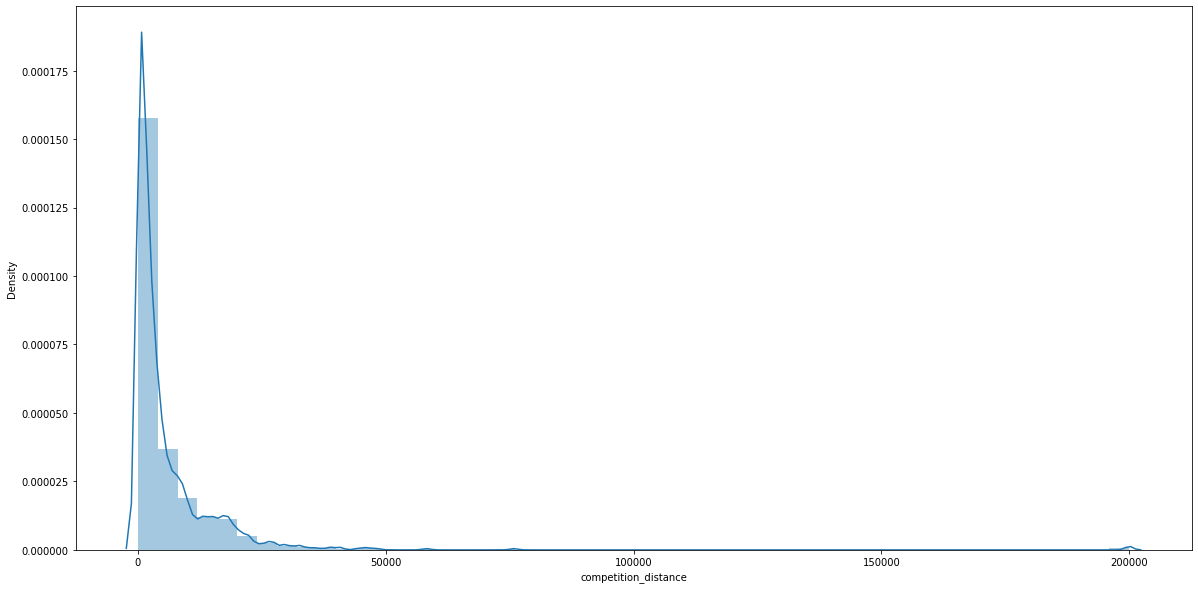

In [21]:
plt.figure(figsize=(20, 10))
sns.distplot( df1['competition_distance'] );

### 1.7.2 Categorical Attributes

In [22]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

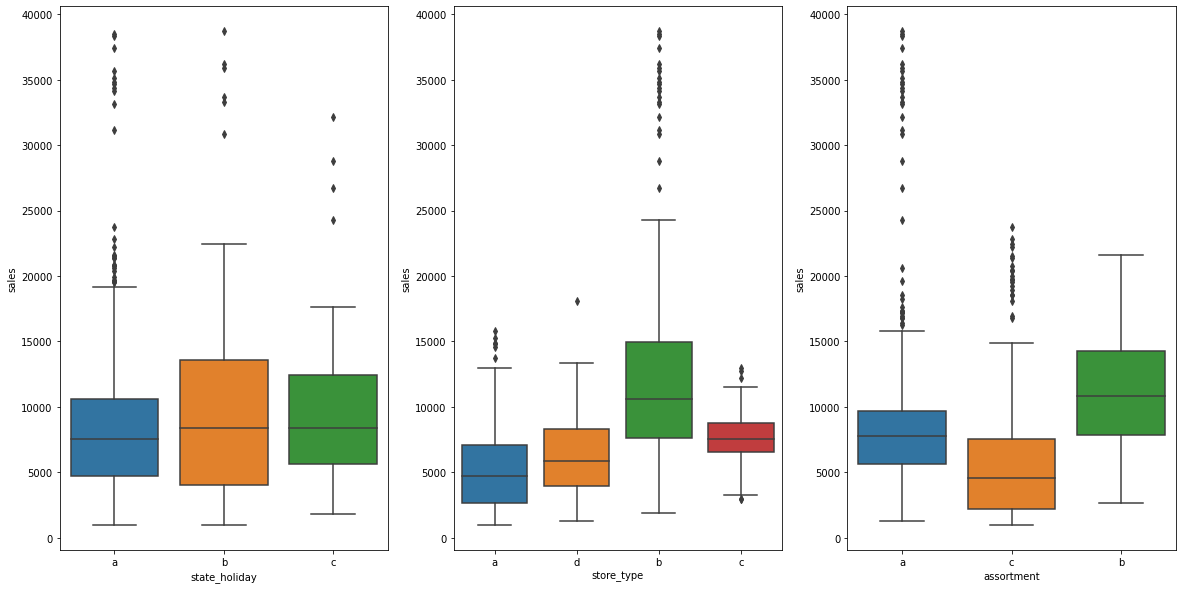

In [23]:
plt.figure(figsize=(20, 10))
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales']  > 0)]

plt.subplot(1, 3, 1 )
sns.boxplot ( x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2 )
sns.boxplot ( x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3 )
sns.boxplot ( x='assortment', y='sales', data=aux1);

# 2.0. PASSO 02 - FEATURE ENGINEERING



In [355]:
df2 = df1.copy()

df2[['sales', 'date']].groupby('sales').sum().reset_index()

KeyError: "None of [Index(['sales', 'date'], dtype='object')] are in the [columns]"

## 2.1. Mapa mental de hipoteses

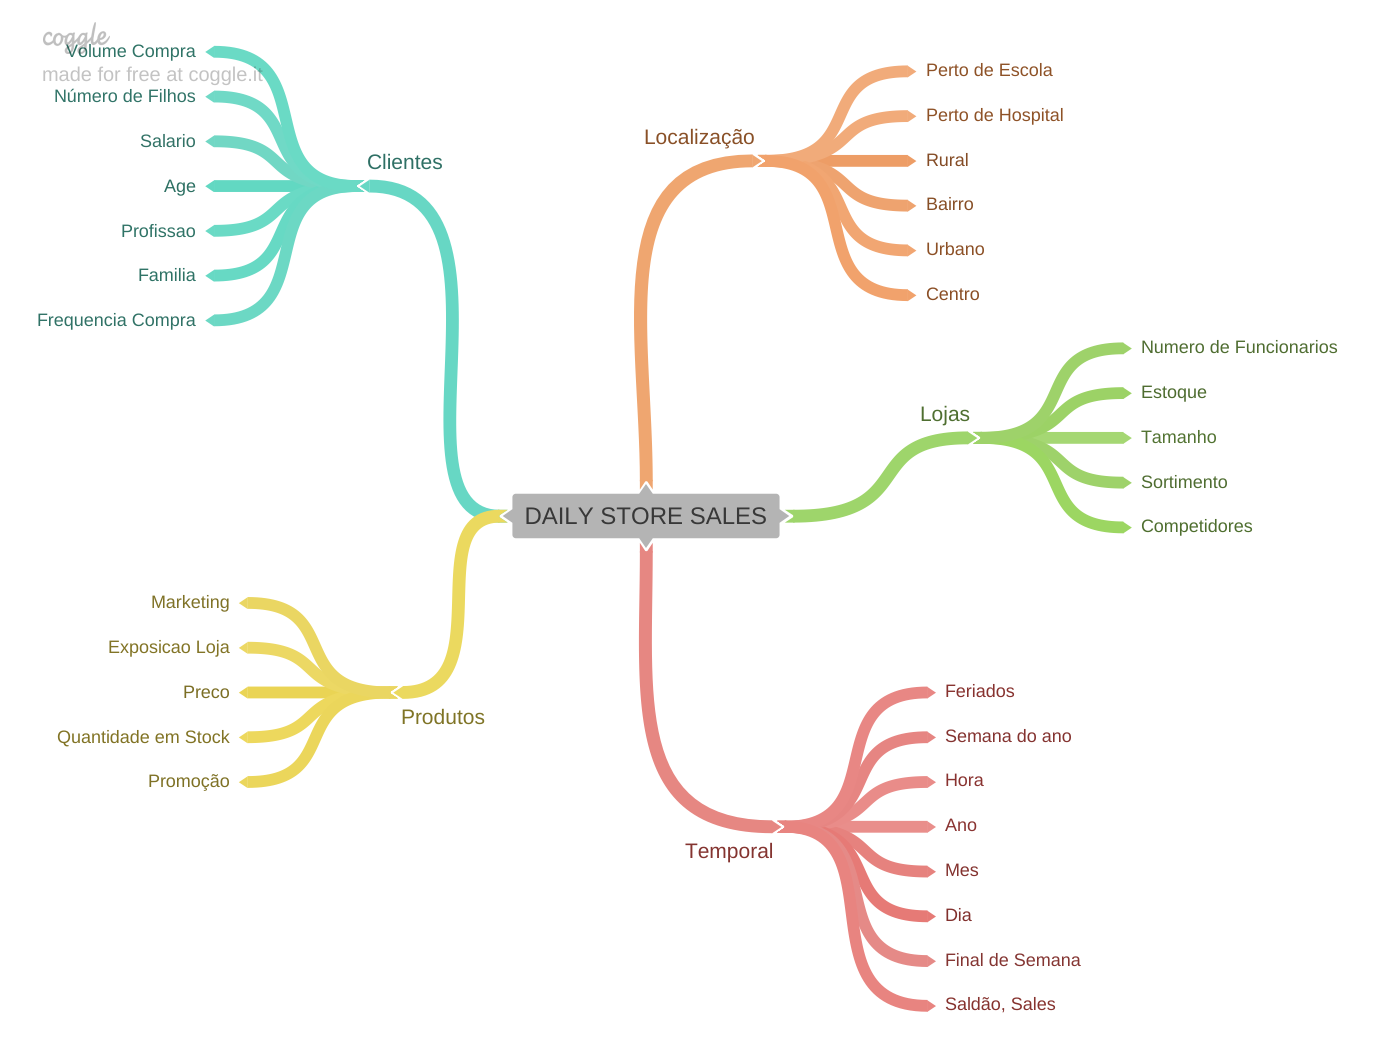

In [25]:
Image('../reports/figures/MindMapHypothesis.png')

## 2.2. Criacao de hipoteses

### 2.2.1. Hipoteses relacionadas a loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais proximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.2.2. Hipoteses do Produto

**1.** Lojas que investem mais em marketing, deveriam vender mais.

**2.** Lojas com maior exposicao de produto deveriam vender mais.

**3.** Lojas com produtos com preco menor deveriam vender mais.

**4.** Lojas com promocoes mais agressivas (descontos maiores), deveriam vender mais.

**5.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promocao deveriam vender mais.

**7.** Lojas com mais promocoes consecutivas deveriam vender mais.

### 2.2.3. Hipoteses do Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.


## 2.2. Lista final de Hipoteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais proximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promocao deveriam vender mais.

**6.** Lojas com mais promocoes consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.
 
**10.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.


## 2.3. Feature Engineering

In [26]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [27]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 03 - FILTRAGEM DE VARIAVEIS

In [28]:
df3 = df2.copy()

In [29]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das linhas 

In [30]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Selecao das Colunas 

In [31]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop(cols_drop, axis=1)

In [32]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

##### * Objetivos 
    - Ganhar experiencia de Negocio
    - Validar Hipoteses de Negocio (Insights)
    - Perceber quais sao as variaveis que sao importantes para o Modelo.

In [33]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

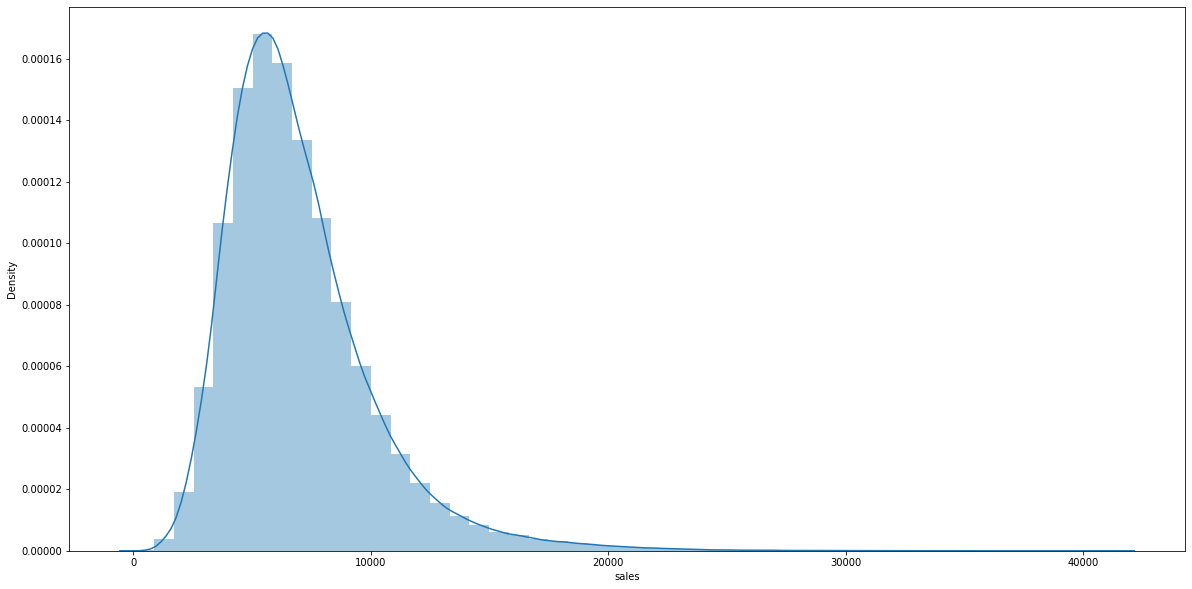

In [34]:
plt.figure(figsize=(20, 10))
sns.distplot(df4['sales']);

### 4.1.2. Numerical Variable

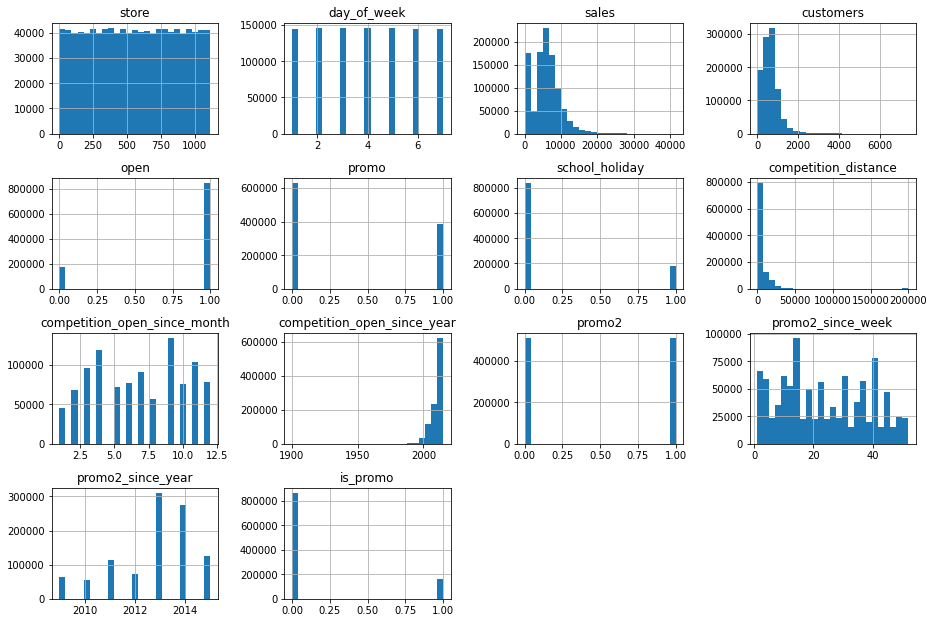

In [35]:
num_attributes.hist(bins=25, figsize=(15,10));
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

### 4.1.3. Categorical Variable

In [36]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

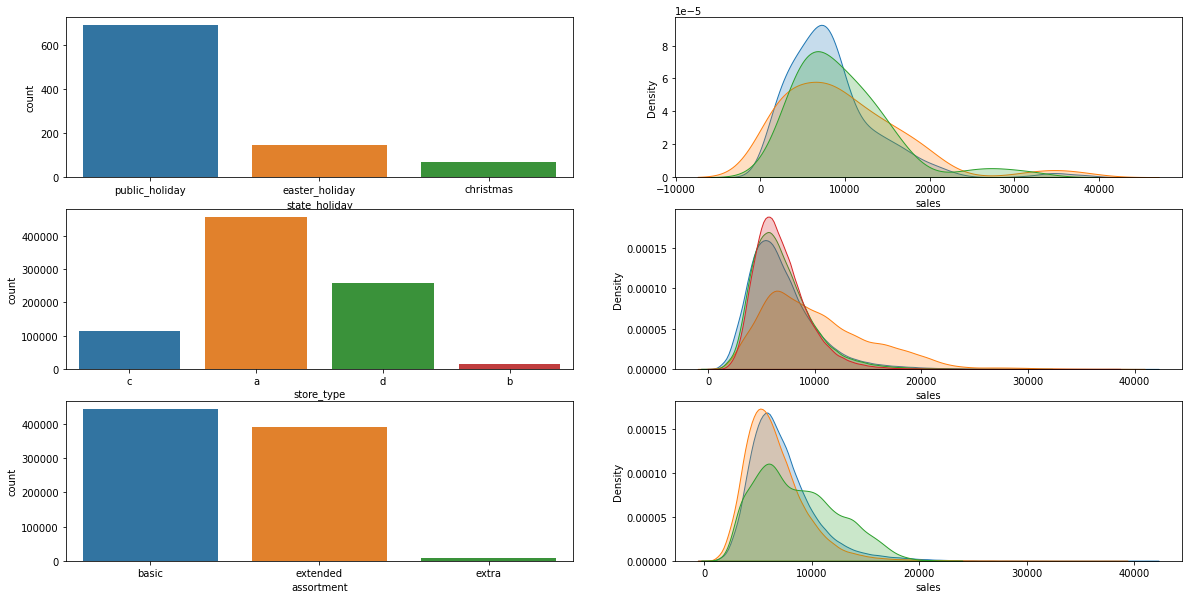

In [37]:
# state_holiday
plt.figure(figsize=(20, 10))

plt.subplot(3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2 )
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

#store_type

plt.subplot(3, 2, 3 )

sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4 )
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

#assortment

plt.subplot(3, 2, 5 )
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6 )

sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True);

## 4.2. Analise Bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais.

*** VERDADEIRA** Lojas com MAIOR SORTIMENTO vendem MAIS

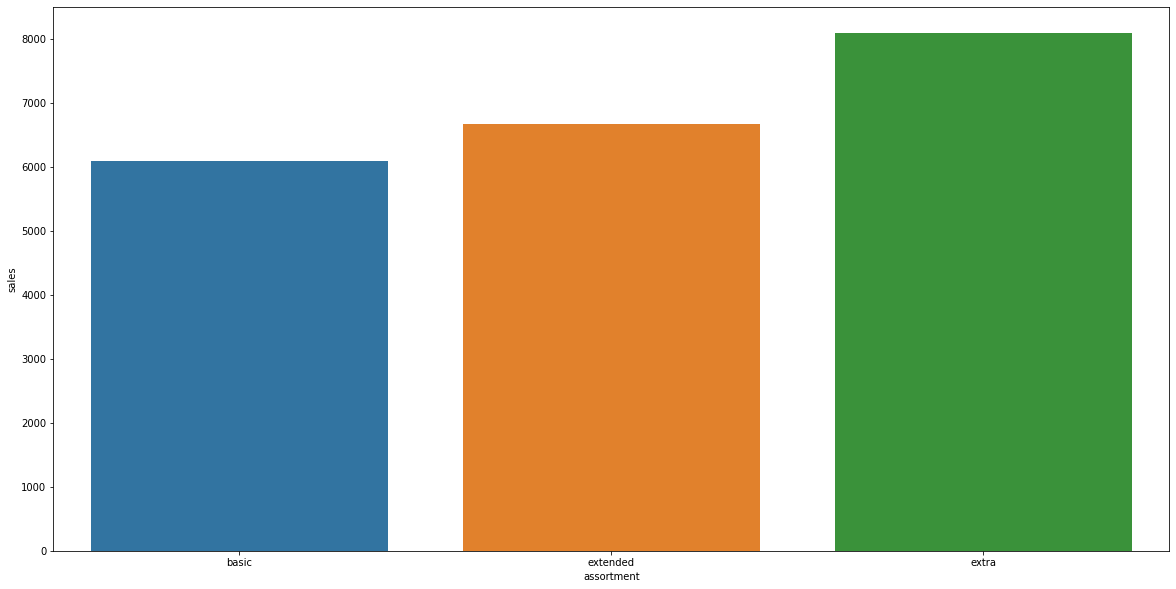

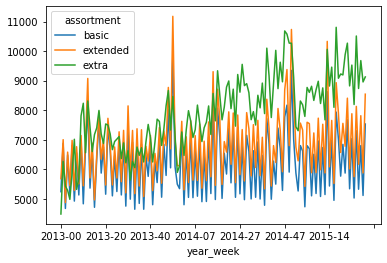

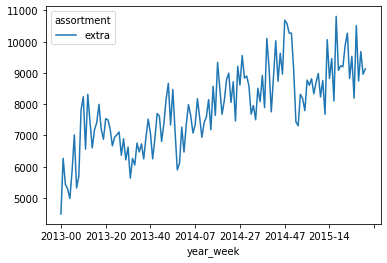

In [38]:
plt.figure(figsize=(20, 10))

aux1 = df4[['assortment', 'sales']].groupby('assortment').median().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).median().reset_index()
aux2.pivot( index='year_week' , columns='assortment' , values='sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week' , columns='assortment' , values='sales').plot();

### **H2.** Lojas com competidores mais proximos deveriam vender menos.

***FALSA** Lojas com COMPETIDORES mais PROXIMOS vendem MAIS}

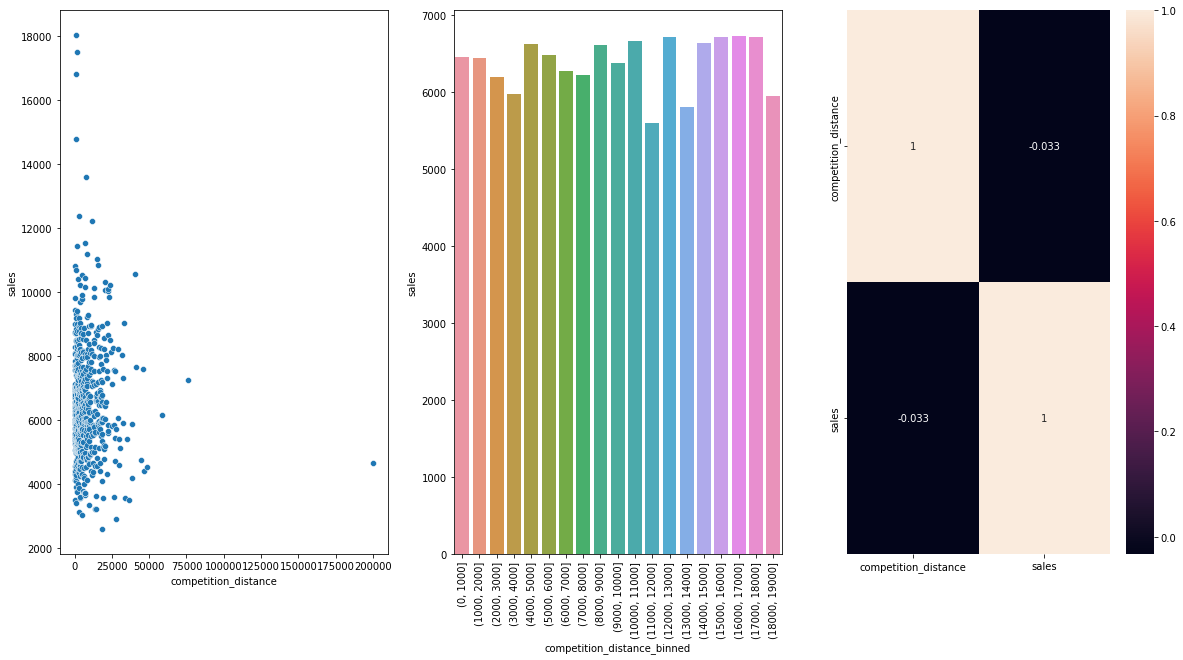

In [39]:
plt.figure(figsize=(20, 10))

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').median().reset_index()

plt.subplot(1, 3, 1 )
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1)

plt.subplot(1, 3, 2 )
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').median().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(1, 3, 3 )
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **3.** Lojas com competidores a mais tempo deveriam vender mais.

***FALSA** Lojas com competidores a mais tempo vendem MENOS.

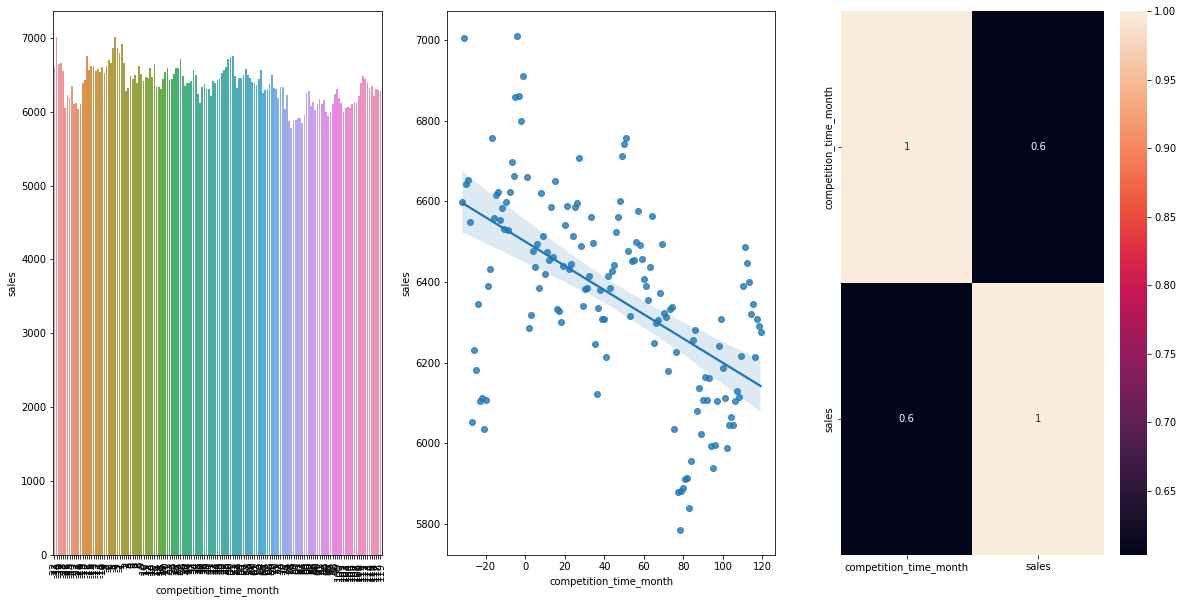

In [40]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').median().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

***Verdadeira** Lojas com promocoes ATIVAS por mais tempo VENDEM MAIS.

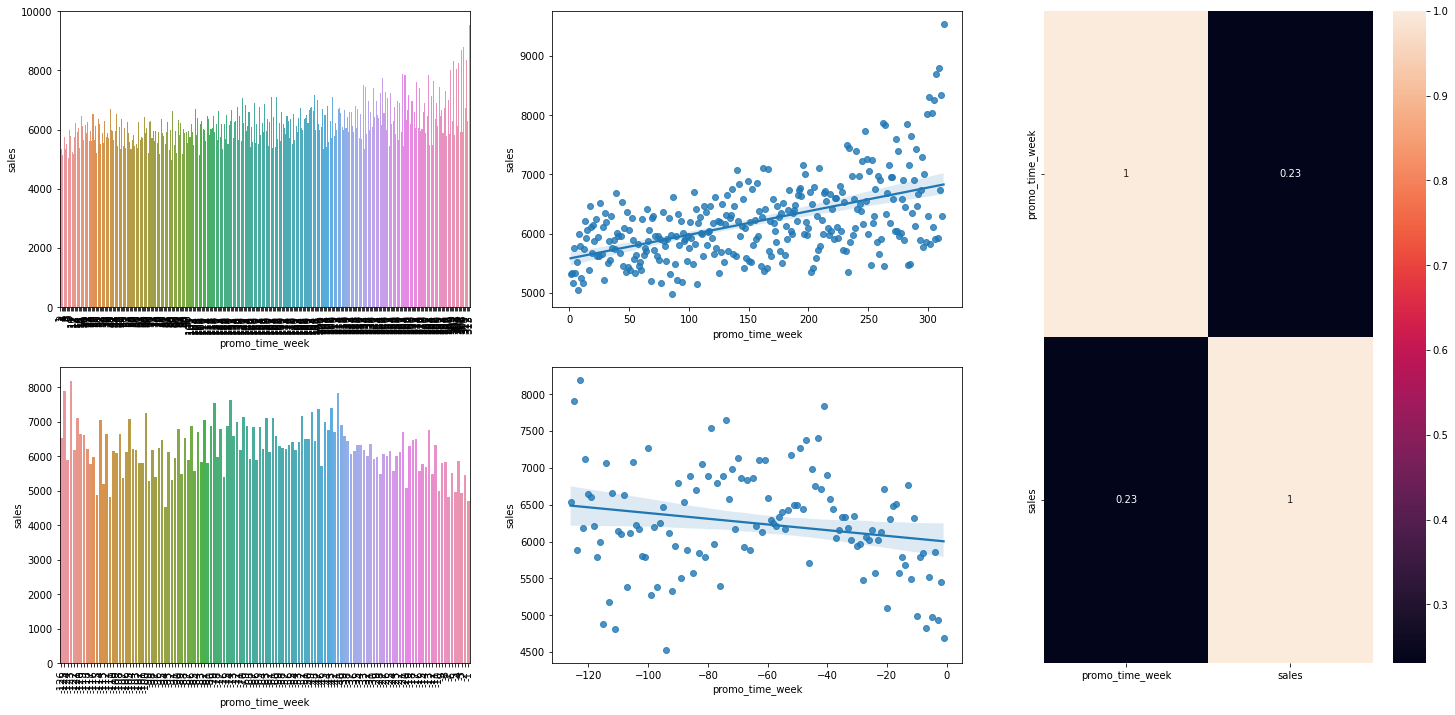

In [41]:
fig = plt.figure(figsize=(25, 12))
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').median().reset_index()

spec = gridspec.GridSpec(2, 3, figure=fig)

plt.subplot(spec[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extended
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(spec[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(spec[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(spec[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(spec[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s>**5.** Lojas com mais dias de promocao deveriam vender mais.</s>

### **6.** Lojas com mais promocoes consecutivas deveriam vender mais.

***FALSA** Lojas com mais promocoes consecutivas vendem menos do que lojas que participam apenas da primeira promocao.

In [42]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).median().reset_index()

,promo,promo2,sales
0,0,0,5757.0000
1,0,1,5181.0000
2,1,0,7950.0000
3,1,1,7358.0000


<Figure size 1440x720 with 0 Axes>

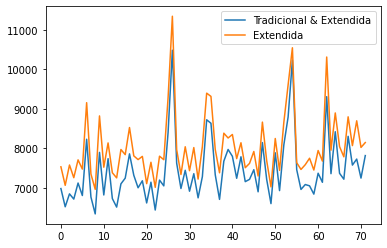

In [43]:
plt.figure(figsize=(20, 10))
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').median().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').median().reset_index()
aux2.plot(ax=ax)

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais


***VERDADE** Apesar de vender bem, o Natal ainda perde para a Pascoa.

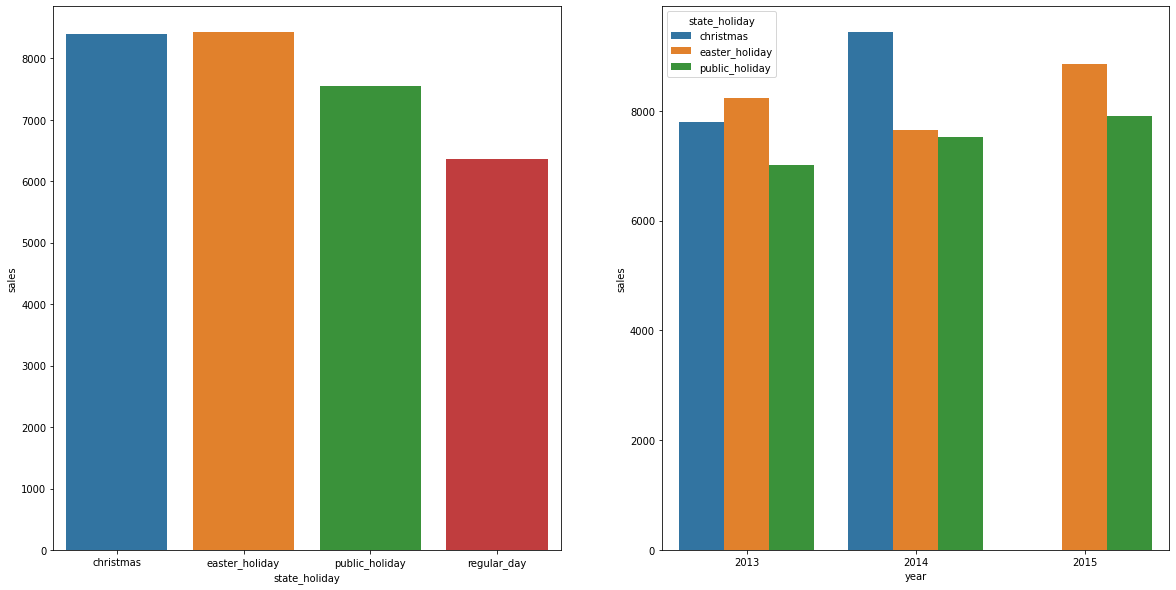

In [44]:
plt.figure(figsize=(20, 10))
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = df4[['state_holiday', 'sales']].groupby('state_holiday').median().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).median().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### **H8.** Lojas deveriam vender mais ao longo dos anos.

***Verdadeira** Ao longo dos anos a media de vendas vai aumentando

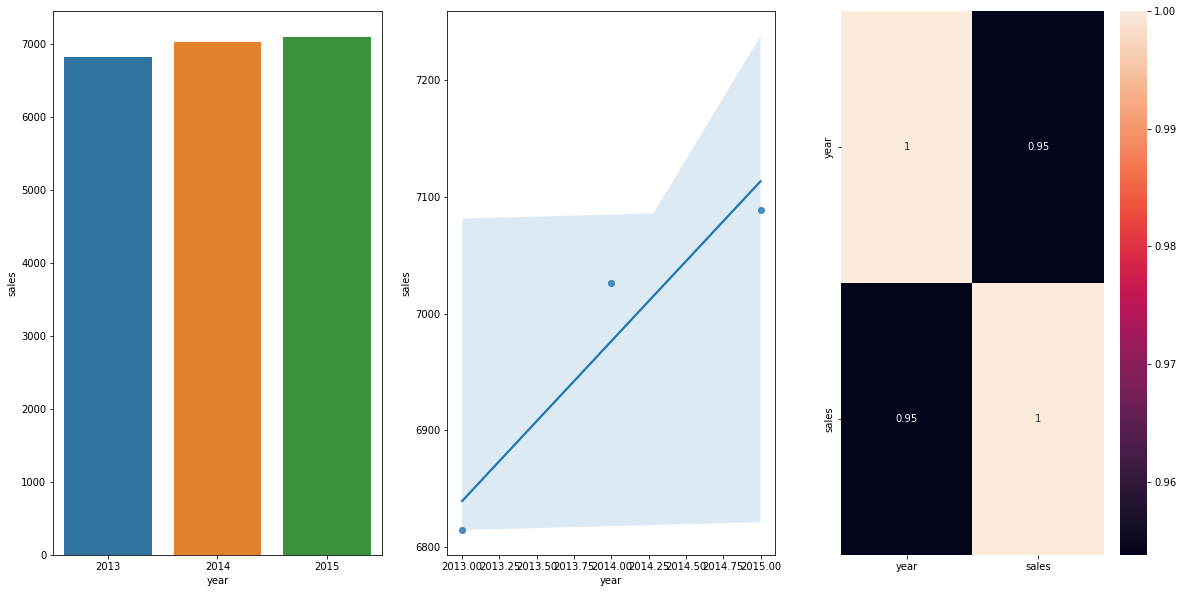

In [45]:
plt.figure(figsize=(20, 10))
aux1 = df4[['year', 'sales']].groupby('year').mean().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.

**VERDADEIRA** Lojas vendem mais no segundo semestre, principalmente no mes de Dezembro

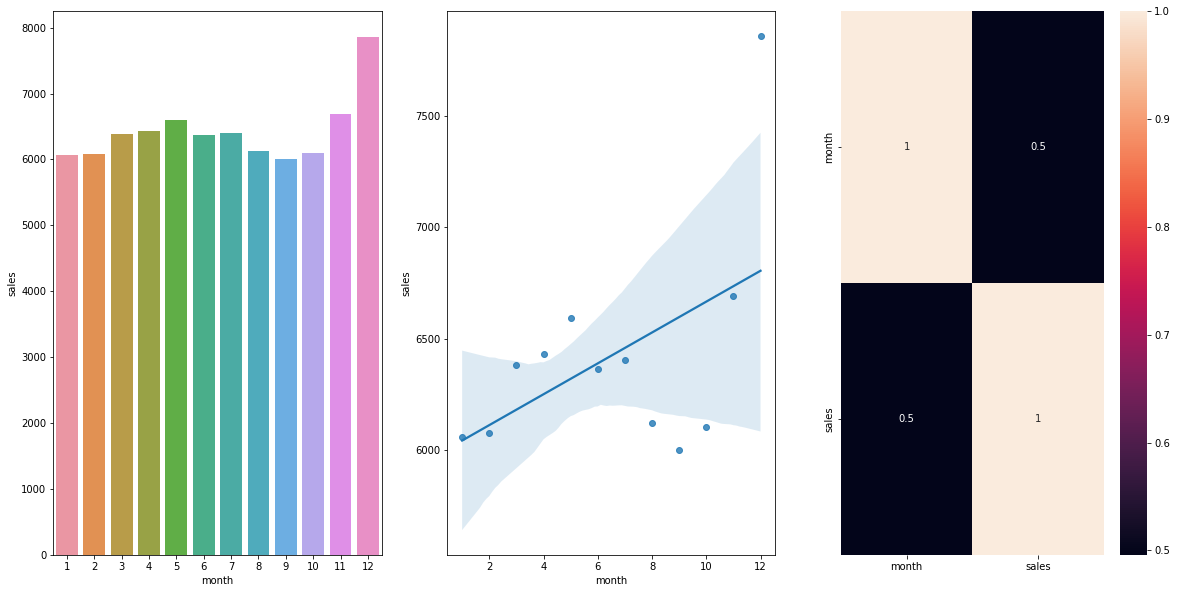

In [46]:
plt.figure(figsize=(20, 10))
aux1 = df4[['month', 'sales']].groupby('month').median().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **10.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**Falso** Lojas vendem mais antes do dia 10

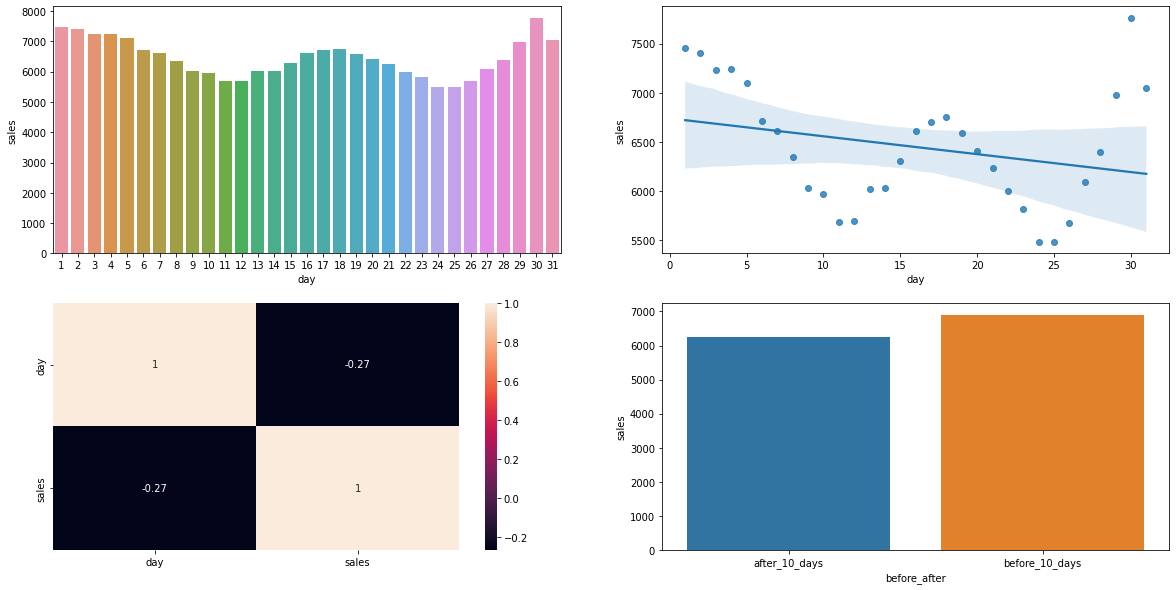

In [47]:
plt.figure(figsize=(20, 10))
aux1 = df4[['day', 'sales']].groupby('day').median().reset_index()
plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days'if x <=10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').median().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);


### **11.** Lojas deveriam vender menos aos finais de semana.

***Verdadeira** Lojas vendem menos nos finais de semana

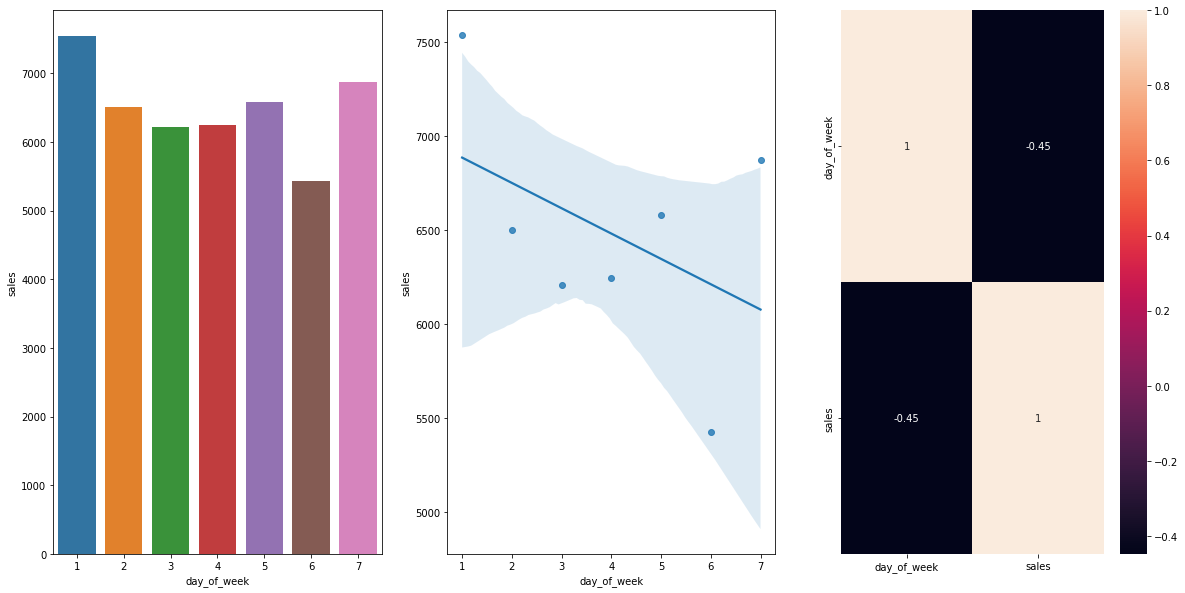

In [48]:
plt.figure(figsize=(20, 10))
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').median().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **12.** Lojas deveriam vender menos durante os feriados escolares.

***FALSA** Lojas vendem em media MAIS nos feriados escolares

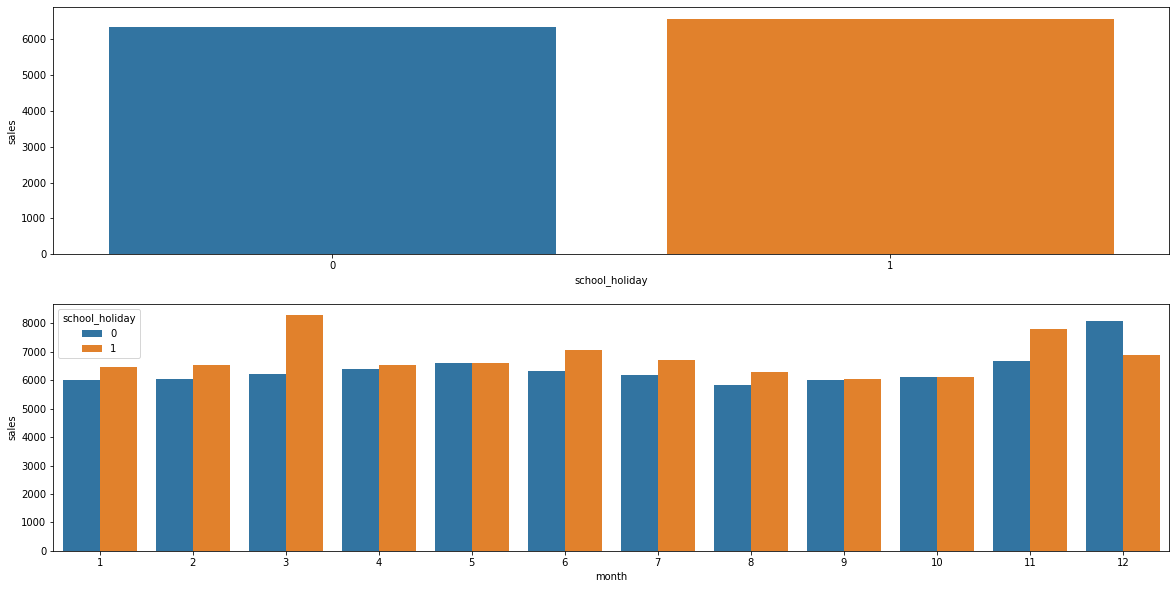

In [49]:
plt.figure(figsize=(20, 10))
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').median().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(2,1,2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).median().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

In [50]:
#cols_selected_boruta

In [51]:
tab = [['Hipoteses', 'Conlusao', 'Relevancia'],
       ['H1', 'VERDADEIRA', 'BAIXA'],
       ['H2', 'FALSA', 'MEDIA'],
       ['H3', 'FALSA', 'ALTA'],
       ['H4', 'VERDADEIRA', 'ALTA'],
       ['H5', '-----', '-----'],
       ['H6', 'FALSA', 'ALTA'],
       ['H7', 'VERDADEIRA', 'BAIXA'],
       ['H8', 'FALSA', 'BAIXA'],
       ['H9', 'VERDADEIRA', 'BAIXA'],
       ['H10', 'FALSA', 'ALTA'],
       ['H11', 'VERDADEIRA', 'BAIXA'],
       ['H12', 'FALSA', 'MEDIA'],
      ]
print(tabulate(tab, headers='firstrow'))

Hipoteses    Conlusao    Relevancia
-----------  ----------  ------------
H1           VERDADEIRA  BAIXA
H2           FALSA       MEDIA
H3           FALSA       ALTA
H4           VERDADEIRA  ALTA
H5           -----       -----
H6           FALSA       ALTA
H7           VERDADEIRA  BAIXA
H8           FALSA       BAIXA
H9           VERDADEIRA  BAIXA
H10          FALSA       ALTA
H11          VERDADEIRA  BAIXA
H12          FALSA       MEDIA


## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

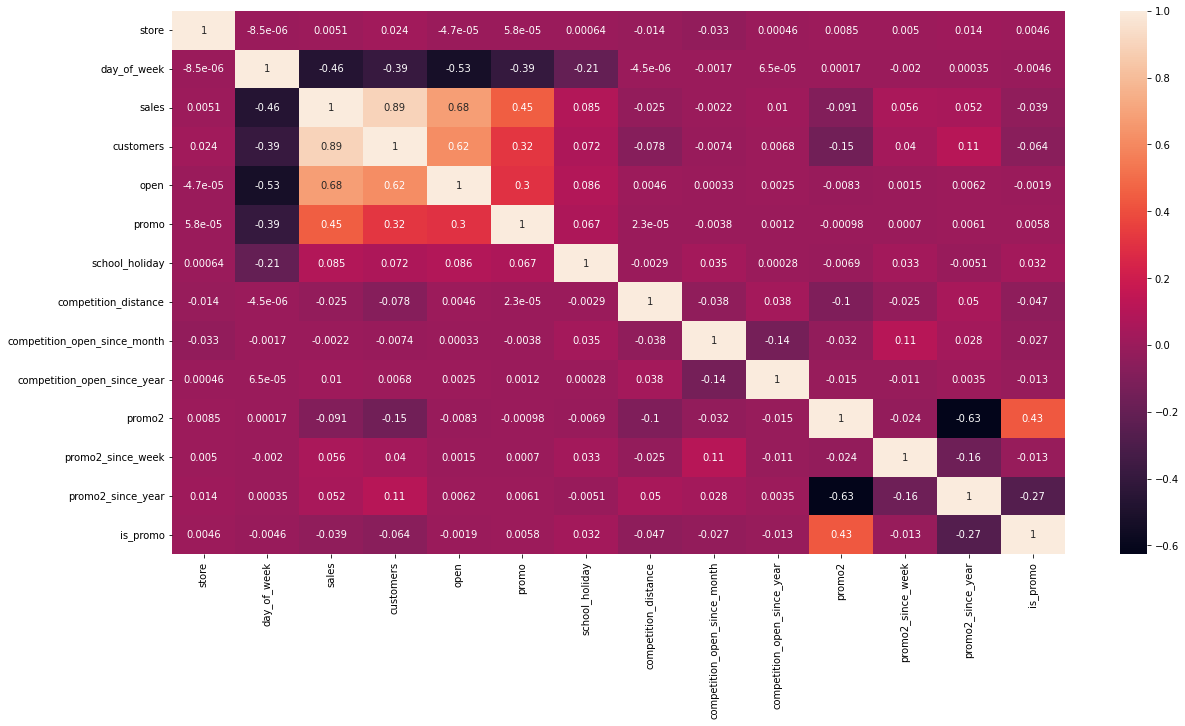

In [52]:
plt.figure(figsize=(20, 10))
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.1. Categorical Attributes

In [53]:
# only categorical data
a = df4.select_dtypes(include='object')

# Calculate cramer_v
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# final data_set
d = pd.DataFrame({'state_holiday':[a1, a2, a3],
              'store_type':[a4, a5, a6],
              'assortment':[a7, a8, a9]})

d = d.set_index(d.columns);

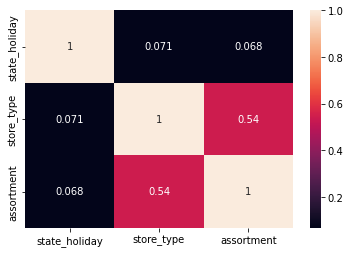

In [54]:
sns.heatmap(d, annot=True);

# 5.0. PASSO 05 - PREPARACAO DE DADOS

In [347]:
df5 = df4.copy()

## 5.1. Normalizacao-

## 5.2. Rescaling

In [350]:
rs = RobustScaler()
mms = MinMaxScaler()
# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('../parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('../parameter/competition_time_month_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('../parameter/year_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('../parameter/promo_time_week_scaler.pkl', 'wb'))

## 5.3. Transformacao

### 5.3.1. Encoding

In [349]:
# state_holiday - One Hot encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Nao tem como saber se tem uma ordem, so foi trocado as letras por numeros
# Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('../parameter/store_type_scaler.pkl', 'wb'))
# assortment = Ordinal Enconding
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].replace(assortment_dict)

### 5.3.2. - Response Variable Transformation

In [58]:
# transformacao de variavel resposta por logarithm transformation

df5['sales'] = np.log1p(df5['sales'])

### 5.3.2. Nature Transformation

In [59]:
#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2.* np.pi/7) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2.* np.pi/7) ) )

#month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2.* np.pi/12) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2.* np.pi/12) ) )

#day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2.* np.pi/30) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2.* np.pi/30) ) )

#week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2.* np.pi/52) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2.* np.pi/52) ) )

# 6.0. PASSO 06 - FEATURE SELECTION

In [60]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [61]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.5686,1,1,2,1,-0.1710,9,...,0,1,-0.9749,-0.2225,-0.5000,-0.8660,0.2079,0.9781,-0.5681,-0.8230
1,2,5,2015-07-31,8.7103,1,1,0,1,-0.2839,11,...,0,1,-0.9749,-0.2225,-0.5000,-0.8660,0.2079,0.9781,-0.5681,-0.8230
2,3,5,2015-07-31,9.0258,1,1,0,1,1.9032,12,...,0,1,-0.9749,-0.2225,-0.5000,-0.8660,0.2079,0.9781,-0.5681,-0.8230
3,4,5,2015-07-31,9.5465,1,1,2,3,-0.2758,9,...,0,1,-0.9749,-0.2225,-0.5000,-0.8660,0.2079,0.9781,-0.5681,-0.8230
4,5,5,2015-07-31,8.4812,1,1,0,1,4.4484,4,...,0,1,-0.9749,-0.2225,-0.5000,-0.8660,0.2079,0.9781,-0.5681,-0.8230


In [62]:
cols_drops = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drops, axis=1)

In [63]:
# primeira data ate o dia 18-06-2015 - dados de treino
# a data a partir 19-06 ate a ultima data vai ser o de teste

df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=7*6)

Timestamp('2015-06-19 00:00:00')

In [64]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train =  X_train['sales']

#test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test =  X_test['sales']

print('Training Min Data: {}'.format(X_train['date'].min()))
print('Training Max Data: {}'.format(X_train['date'].max()))

print('\nTest Min Data: {}'.format(X_test['date'].min()))
print('Test Max Data: {}'.format(X_test['date'].max()))

Training Min Data: 2013-01-01 00:00:00
Training Max Data: 2015-06-18 00:00:00

Test Min Data: 2015-06-19 00:00:00
Test Max Data: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [65]:
## training and test dataset for Boruta
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel()

## define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

## define boruta
#boruta_1 = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n)

In [66]:
#cols_selected = boruta_1.support_.tolist()

#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )

#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

### 6.2.1. Best Features From Boruta

In [67]:
#cols_selected_boruta

#marcado como comentario. Variavel so roda quando o boruta roda.

In [68]:
#cols_not_selected_boruta

#marcado como comentario. Variavel so roda quando o boruta roda.

## 6.3. Manual Feature Selection

In [69]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_cos',
    'month_sin',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)
#cols_selected_boruta.extend(feat_to_add)

In [70]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# 7.0. PASSO 07 - MACHINE LEARNING MODELLING

In [71]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# time series data preparation

x_training = X_train[cols_selected_boruta_full]

## 7.1. Average Model

In [72]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# perfomance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.8004,0.2064,1835.1355


## 7.2. Linear Regression Model

In [73]:
#model
lr = LinearRegression().fit(x_train, y_train)


#prediction

yhat_lr = lr.predict(x_test)

#perfomance

lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.0898,0.2927,2671.0492


### 7.2.1 Linear Regression Model - Cross Validation

In [74]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1992.27+/-41.68,0.29+/-0.01,2846.37+/-87.77


## 7.3. Linear Regression Regularized Model

In [75]:
#model
lrr = Lasso( alpha=0.01 ).fit(x_train, y_train)


#prediction

yhat_lrr = lrr.predict(x_test)

#perfomance

lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.7049,0.2891,2744.4517


### 7.3.1. Lasso - Cross Valadition

In [76]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2035.84+/-54.02,0.29+/-0.0,2964.68+/-89.66


## 7.4. Random Forest Regressor

In [77]:
#model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit(x_train, y_train)


#prediction

yhat_rf = rf.predict(x_test)

#perfomance

rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.3939,0.0998,1009.0086


### 7.4.1 Random Forest Regressor - Cross Validation

In [78]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


 Kfold Number 5

 Kfold Number 4

 Kfold Number 3

 Kfold Number 2

 Kfold Number 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,829.99+/-105.58,0.12+/-0.02,1263.55+/-191.19


## 7.5. XGBoost Regressor

In [79]:
#model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100, 
                             eta=0.0,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)


#prediction

yhat_xgb = model_xgb.predict(x_test)

#perfomance

xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6994.5139,0.9999,7628.1868


### 7.4.1 Random XGBoost - Cross Validation


In [80]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


 Kfold Number 5

 Kfold Number 4

 Kfold Number 3

 Kfold Number 2

 Kfold Number 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7267.6+/-110.34,1.0+/-0.0,7906.3+/-126.36


## 7.6. Compare Model's Perfomance

### 7.6.1. Single Perfomance

In [81]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.3939,0.0998,1009.0086
0,Average Model,1354.8004,0.2064,1835.1355
0,Linear Regression,1867.0898,0.2927,2671.0492
0,Linear Regression - Lasso,1891.7049,0.2891,2744.4517
0,XGBoost Regressor,6994.5139,0.9999,7628.1868


In [82]:
model = LinearRegression()
a = cross_validation(x_training, 5, 'Linear Regression', model)
a

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1992.27+/-41.68,0.29+/-0.01,2846.37+/-87.77


### 7.6.2. Real Perfomance - Cross Validation

In [83]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv,xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1992.27+/-41.68,0.29+/-0.01,2846.37+/-87.77
0,Lasso,2035.84+/-54.02,0.29+/-0.0,2964.68+/-89.66
0,Random Forest Regressor,829.99+/-105.58,0.12+/-0.02,1263.55+/-191.19
0,XGBoost Regressor,7267.6+/-110.34,1.0+/-0.0,7906.3+/-126.36


# 8.0. PASSO 08 - HYPERPARAMENT FINE TUNNING

## 8.1 Random Search

In [84]:
#param = {
 #   'n_estimators':[1500, 1700, 2500, 3000, 3500],
  #  'eta':[0.01, 0.03],
   # 'max_depth':[3, 5, 9],
    #'subsample':[0.1, 0.5, 0.7],
    #'colsample_bytree':[0.3, 0.7, 0.9],
    #'min_child_weight':[3, 8, 15]
       # }

#MAX_EVAL = 10

In [85]:
#final_result = pd.DataFrame()

#for i in range(MAX_EVAL):
    # choose values for parameters randomly
 #   hp = {k:random.sample(v, 1)[0]for k, v in param.items()}
  #  print(hp)
    #model
   # model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
    #                             n_estimators=hp['n_estimators'], 
     #                            eta=hp['eta'],
      #                           max_depth=hp['max_depth'],
       #                          subsample=hp['subsample'],
        #                         colsample_bytree=hp['colsample_bytree'],
         #                        min_child_weight=hp['min_child_weight'])


    #perfomance                                
    #result = cross_validation(x_training, 2, 'XGBooster Regressor', model_xgb, verbose=False)
    #final_result = pd.concat([final_result, result])
    
#final_result

## 8.2. Final Model

In [86]:
param_tuned = {
    'n_estimators':2500,
    'eta':0.03,
    'max_depth':9,
    'subsample':0.1,
    'colsample_bytree':0.7,
    'min_child_weight':8
        }

In [87]:
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=param_tuned['n_estimators'], 
                             eta=param_tuned['eta'],
                             max_depth=param_tuned['max_depth'],
                             subsample=param_tuned['subsample'],
                             colsample_bytree=param_tuned['colsample_bytree'],
                             min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

# prediction

yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

#perfomance                                
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,640.9477,0.0936,934.5904


In [88]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))

In [89]:
mpe

0.0008759848448142449

# 9.0. PASSO 09 - TRADUCAO E INTERPRETACAO DE ERRO

In [90]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales']  = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1. Business Performance

In [91]:
# sum of predictions

df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios 
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
d92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [92]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,MAE,MAPE,worst_scenario,best_scenario
291,292,105874.4844,3374.1916,0.5684,102500.2928,109248.6759
908,909,239132.5000,7579.7745,0.5139,231552.7255,246712.2745
594,595,365640.8125,4420.8702,0.3054,361219.9423,370061.6827
875,876,204158.2656,3920.3647,0.3047,200237.9009,208078.6303
721,722,346820.2500,1824.9798,0.2453,344995.2702,348645.2298


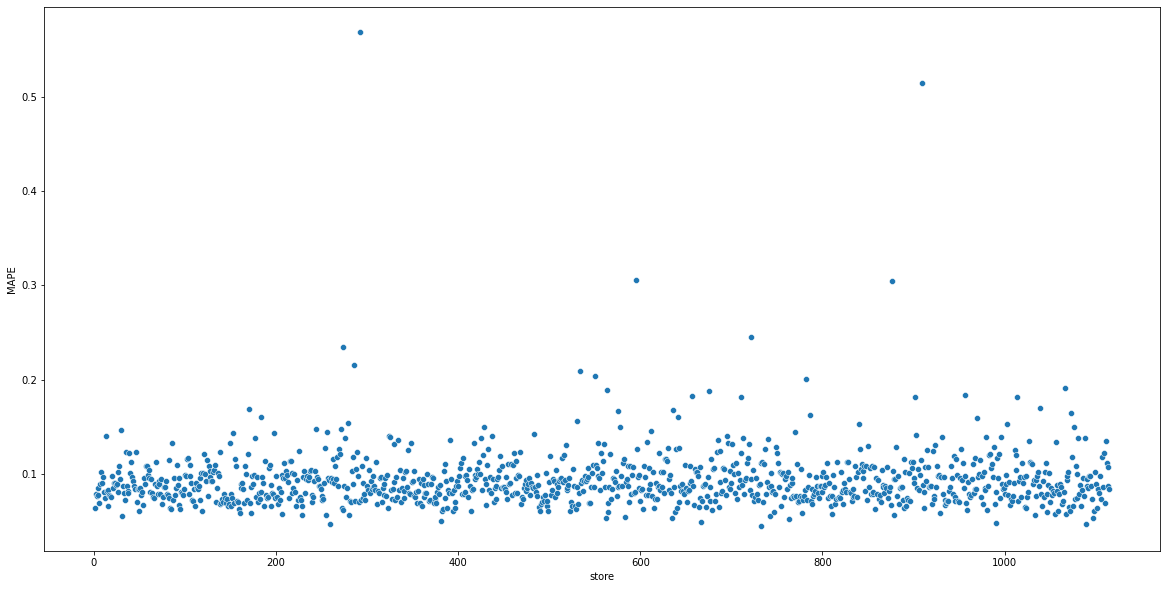

In [93]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x='store', y='MAPE', data=df92);

## 9.2. Total Performance

In [94]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenario', 0:'Values'})
df93['Values']= df93['Values'].map( 'R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$284,345,472.00"
1,worst_scenario,"R$283,626,861.83"
2,best_scenario,"R$285,064,088.07"


## 9.3. Machine Learning Performance   

In [95]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

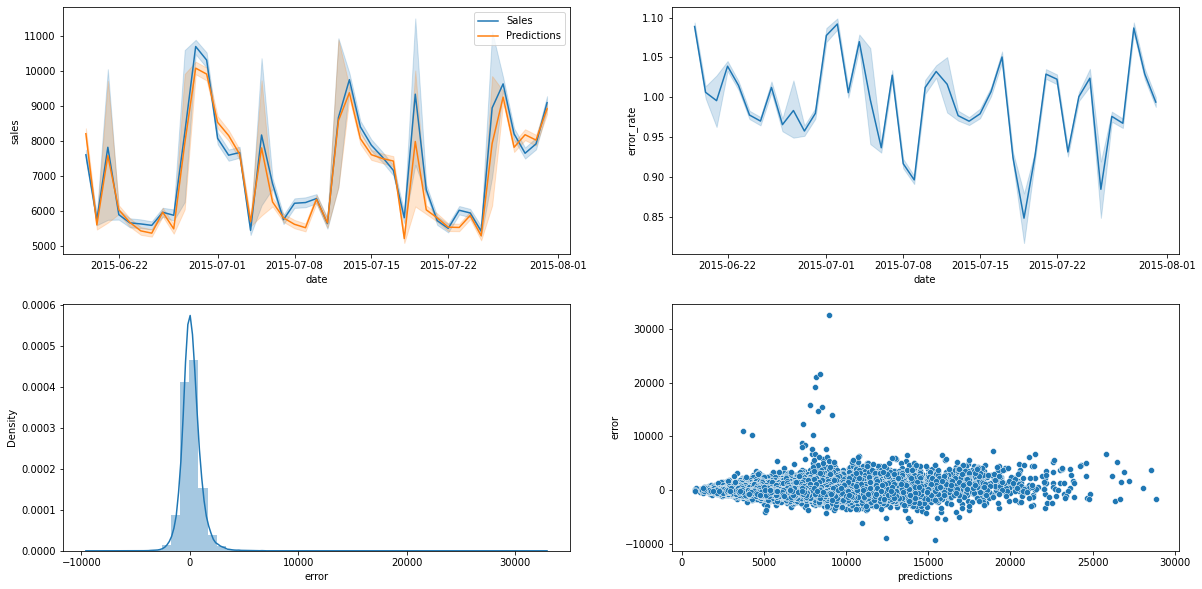

In [96]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='Sales')
sns.lineplot(x='date', y='predictions', data=df9, label='Predictions')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error']);


# 10.0. PASSO 10 - DEPLOY MODEL TO PRODUCTION

In [245]:
# SAVE TRAINED MODEL

pickle.dump(model_xgb_tuned, open('/home/danilosantana/repos/rossmann-store-sales-env/models/model_rossmann.pkl', 'wb'))

## 10.1. Rossmann Class

In [370]:
import pickle
import inflection
import pandas as pd 
import numpy as np 
import math 
import datetime

class Rossmann(object):
    def __init__(self):
        self.home_path                     = '/home/danilosantana/repos/rossmann-store-sales-env/'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))

    def data_cleaning(self, df1):
        
        ## 1.1. rename columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
               'CompetitionDistance', 'CompetitionOpenSinceMonth',
               'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
               'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types

        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5 Fillout NA
        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        # competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        # competition_open_since_year      
        df1['competition_open_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        # promo2_since_week    
        df1['promo2_since_week'] = df1.apply (lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # promo2_since_year
        df1['promo2_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # promo_interval
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Set', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply (lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        ## 1.6. Change Types

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
    
    def feature_engineering(self, df2):
    
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        #year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # 3.0. PASSO 03 - FILTRAGEM DE VARIAVEIS

        ## 3.1. Filtragem das linhas 

        df2 = df2[(df2['open'] != 0)]

        ## 3.2. Selecao das Colunas 

        cols_drop = ['open', 'promo_interval', 'month_map']

        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
    def data_preparation(self, df5):
    

        ## 5.2. Rescaling

        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values)

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values)

        # year
        df5['year'] = self.year_scaler.transform(df5[['year']].values)



        ### 5.3.1. Encoding

        # state_holiday - One Hot encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # Label Encoding
        df5['store_type'] = self.store_type.scaler.transform(df5['store_type'])
        # assortment = Ordinal Enconding
        assortment_dict = {'basic':1, 'extra':2, 'extended':3}
        df5['assortment'] = df5['assortment'].replace(assortment_dict)
        
        ### 5.3.2. Nature Transformation
        #day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2.* np.pi/7) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2.* np.pi/7) ) )

        #month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2.* np.pi/12) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2.* np.pi/12) ) )

        #day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2.* np.pi/30) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2.* np.pi/30) ) )

        #week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2.* np.pi/52) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2.* np.pi/52) ) )
        
        cols_selected = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month','competition_open_since_year',    
                          'promo2','promo2_since_week','promo2_since_year','competition_time_month','promo_time_week','day_of_week_sin','day_of_week_cos','month_cos',
                          'month_sin','day_sin','day_cos','week_of_year_sin','week_of_year_cos']
        
        return df5[cols_selected]
    
    
    def get_prediction(self, model, original_data, test_data):
        #prediction
        pred = model.predict(test_data)
        
        #join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')


## 10.2. API Handler

In [313]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

#loading model
model = pickle.load(open('/home/danilosantana/repos/rossmann-store-sales-env/models/model_rossmann.pkl', 'rb'))

#initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance(test_json, dict):# unique exemple
            test_raw = pd.DataFrame(test_json, index=[0])
        else: # multiple exemples
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        # instantiate Rossman Class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
    
        return df_response
        
    else:
        return Response('{}', status=200, mimetype='application/json') 
        
if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Tester

In [314]:
import requests

In [324]:
df_store_raw.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [325]:
df10 = pd.read_csv('../raw/test.csv')

In [326]:
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

#choose store for predction

df_test = df_test[df_test['Store'] == 22]

# remove closed day
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [327]:
# convert Dataframa to json

data = json.dumps(df_test.to_dict(orient='records'))

In [378]:
# api call

url = 'http://0.0.0.0:5000/rossmann/predict'
header = {'Content-type':'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [379]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [381]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,22,4,2015-09-17T00:00:00.000Z,1.0000,1,regular_day,0,a,basic,1040.0000,...,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,4548.4165
1,22,3,2015-09-16T00:00:00.000Z,1.0000,1,regular_day,0,a,basic,1040.0000,...,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,4514.0718
2,22,2,2015-09-15T00:00:00.000Z,1.0000,1,regular_day,0,a,basic,1040.0000,...,2015,9,15,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,4985.6123
3,22,1,2015-09-14T00:00:00.000Z,1.0000,1,regular_day,1,a,basic,1040.0000,...,2015,9,14,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,5830.7700
4,22,6,2015-09-12T00:00:00.000Z,1.0000,0,regular_day,0,a,basic,1040.0000,...,2015,9,12,37,2015-36,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,172,2784.1060
